In [ ]:
!pip install timm
!pip install omegaconf
!pip install pycocotools
!pip install effdet

In [14]:
import sys
import torch
import math
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob

SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(SEED)

In [ ]:
marking = pd.read_csv('../input/label-train-df/train_df.csv')
for i, column in enumerate(['x_min', 'y_min', 'w', 'h']):
    marking[column] = marking[column]*512
marking.head()

In [ ]:
from sklearn.model_selection import StratifiedKFold
skf  =  StratifiedKFold(n_splits = 5, random_state = 42,shuffle = True)
folds = marking.copy()
for f,(tr_idx,val_idx) in enumerate(skf.split(folds,folds.class_id)):
    folds.loc[val_idx,'fold'] = int(f)
folds['fold'] = folds['fold'].astype(int)

folds.head()

In [ ]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
                                     val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [ ]:
TRAIN_ROOT_PATH = '../input/vinbigdata-512-image-dataset/vinbigdata/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        if self.test or random.random() > 0.5:
            image, boxes, labels = self.load_image_and_boxes(index)
        else:
            image, boxes, labels = self.load_mosaic(index)

        target = {}
        target['boxes'] = boxes  # format x_min, y_min, x_max, y_max
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        labels = records['source'].values
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes , labels  # format x_min, y_min, x_max, y_max
    
    
    def load_mosaic(self, index):
    # loads images in a mosaic

    labels4 = []
    s = 512
    xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
    indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
    for i, index in enumerate(indices):
        # Load image
        img,  boxes , labels  = self.load_image_and_boxes(index)
        w, h = 512, 512
        # place img in img4
        if i == 0:  # top left
            img4 = np.full((s * 2, s * 2, img.shape[2]), 114, dtype=np.uint8)  # base image with 4 tiles
            x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
        elif i == 1:  # top right
            x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
            x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
        elif i == 2:  # bottom left
            x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
        elif i == 3:  # bottom right
            x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
            x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

        img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]  # img4[ymin:ymax, xmin:xmax]
        padw = x1a - x1b
        padh = y1a - y1b

        # Labels
        x = boxes
        labels = x.copy()
        if x.size > 0:  # Normalized xywh to pixel xyxy format
            labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
            labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
            labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
            labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
        labels4.append(labels)

    # Concat/clip labels
    if len(labels4):
        labels4 = np.concatenate(labels4, 0)
        # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
        np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

    # Augment
    # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
    img4, labels4 = random_affine(img4, labels4,
                                  degrees=1.98 * 2,
                                  translate=0.05 * 2,
                                  scale=0.05 * 2,
                                  shear=0.641 * 2,
                                  border=-s // 2)  # border to remove

    return img4, labels4

In [7]:
marking = pd.read_csv('../input/label-train-df/train_df.csv') # thay bằng path dẫn đến file train_df.csv

labels_array = [np.zeros((0, 5), dtype=np.float32)] * len(marking['image_id'].unique())

for i, img_id in enumerate(marking['image_id'].unique()):
    records = marking[marking['image_id'] == img_id]
    boxesyolo = records[['class_id', 'x_mid', 'y_mid', 'w', 'h']].values
    labels_array[i] = np.array(boxesyolo)

# print(labels_array)


In [8]:
from sklearn.model_selection import StratifiedKFold
skf  =  StratifiedKFold(n_splits = 5, random_state = 42,shuffle = True)
folds = marking.copy()
for f,(tr_idx,val_idx) in enumerate(skf.split(folds,folds.class_id)):
    folds.loc[val_idx,'fold'] = int(f)
folds['fold'] = folds['fold'].astype(int)

folds.head()

,Unnamed: 0,image_id,class_id,x_min,y_min,x_max,y_max,x_mid,y_mid,w,h,area,fold
0,0,9a5094b2563a1ef3ff50dc5c7ff71345,0,0.505769,0.306079,0.624519,0.413527,0.565144,0.359803,0.118750,0.107449,0.012760,0
1,1,9a5094b2563a1ef3ff50dc5c7ff71345,11,0.860096,0.740154,0.901442,0.852740,0.880769,0.796447,0.041346,0.112586,0.004655,1
2,2,9a5094b2563a1ef3ff50dc5c7ff71345,10,0.860096,0.740154,0.901442,0.852740,0.880769,0.796447,0.041346,0.112586,0.004655,0
3,3,9a5094b2563a1ef3ff50dc5c7ff71345,3,0.332051,0.579766,0.797436,0.769549,0.564744,0.674658,0.465385,0.189783,0.088322,4
4,4,051132a778e61a86eb147c7c6f564dfe,11,0.690972,0.156944,0.782986,0.209722,0.736979,0.183333,0.092014,0.052778,0.004856,0


In [91]:
def get_train_transforms():
    return A.Compose(
        [
            A.OneOf([
#                 A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, 
#                                      val_shift_limit=0.2, p=0.9),
                A.RandomBrightnessContrast(brightness_limit=0.2, 
                                           contrast_limit=0.2, p=0.9),
            ],p=0.9),
            A.HorizontalFlip(p=0.5),
            A.Resize(height=512, width=512, p=1),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [92]:
def random_affine(img, targets=(), degrees=10, translate=.1, scale=.1, shear=10, border=0):
    # torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(.1, .1), scale=(.9, 1.1), shear=(-10, 10))
    # https://medium.com/uruvideo/dataset-augmentation-with-random-homographies-a8f4b44830d4

    if targets is None:  # targets = [cls, xyxy]
        targets = []
    height = img.shape[0] + border * 2
    width = img.shape[1] + border * 2

    # Rotation and Scale
    R = np.eye(3)
    a = random.uniform(-degrees, degrees)
    # a += random.choice([-180, -90, 0, 90])  # add 90deg rotations to small rotations
    s = random.uniform(1 - scale, 1 + scale)
    R[:2] = cv2.getRotationMatrix2D(angle=a, center=(img.shape[1] / 2, img.shape[0] / 2), scale=s)

    # Translation
    T = np.eye(3)
    T[0, 2] = random.uniform(-translate, translate) * img.shape[0] + border  # x translation (pixels)
    T[1, 2] = random.uniform(-translate, translate) * img.shape[1] + border  # y translation (pixels)

    # Shear
    S = np.eye(3)
    S[0, 1] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # x shear (deg)
    S[1, 0] = math.tan(random.uniform(-shear, shear) * math.pi / 180)  # y shear (deg)

    # Combined rotation matrix
    M = S @ T @ R  # ORDER IS IMPORTANT HERE!!
    if (border != 0) or (M != np.eye(3)).any():  # image changed
        img = cv2.warpAffine(img, M[:2], dsize=(width, height), flags=cv2.INTER_LINEAR, borderValue=(114, 114, 114))

    # Transform label coordinates
    n = len(targets)
    if n:
        # warp points
        xy = np.ones((n * 4, 3))
        xy[:, :2] = targets[:, [1, 2, 3, 4, 1, 4, 3, 2]].reshape(n * 4, 2)  # x1y1, x2y2, x1y2, x2y1
        xy = (xy @ M.T)[:, :2].reshape(n, 8)

        # create new boxes
        x = xy[:, [0, 2, 4, 6]]
        y = xy[:, [1, 3, 5, 7]]
        xy = np.concatenate((x.min(1), y.min(1), x.max(1), y.max(1))).reshape(4, n).T

        # # apply angle-based reduction of bounding boxes
        # radians = a * math.pi / 180
        # reduction = max(abs(math.sin(radians)), abs(math.cos(radians))) ** 0.5
        # x = (xy[:, 2] + xy[:, 0]) / 2
        # y = (xy[:, 3] + xy[:, 1]) / 2
        # w = (xy[:, 2] - xy[:, 0]) * reduction
        # h = (xy[:, 3] - xy[:, 1]) * reduction
        # xy = np.concatenate((x - w / 2, y - h / 2, x + w / 2, y + h / 2)).reshape(4, n).T

        # reject warped points outside of image
        xy[:, [0, 2]] = xy[:, [0, 2]].clip(0, width)
        xy[:, [1, 3]] = xy[:, [1, 3]].clip(0, height)
        w = xy[:, 2] - xy[:, 0]
        h = xy[:, 3] - xy[:, 1]
        area = w * h
        area0 = (targets[:, 3] - targets[:, 1]) * (targets[:, 4] - targets[:, 2])
        ar = np.maximum(w / (h + 1e-16), h / (w + 1e-16))  # aspect ratio
        i = (w > 4) & (h > 4) & (area / (area0 * s + 1e-16) > 0.2) & (ar < 10)

        targets = targets[i]
        targets[:, 1:5] = xy[i]

    return img, targets

In [97]:
TRAIN_ROOT_PATH = '../input/vinbigdata-512-image-dataset/vinbigdata/train' # thay bằng Path đến dataset

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, labels, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
        self.labels = labels

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        
        # if self.test or random.random() > 0.5:
        #     image, boxes, labels = self.load_image_and_boxes(index)
        # else:
        image, boxes, labels = self.load_mosaic(index)
        target = {}
        target['boxes'] = boxes/512  # format x_min, y_min, x_max, y_max
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        print(image.shape)
        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': np.array(image),
                    'bboxes': target['boxes']/512,
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.png', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        labels = records['class_id'].values
        boxes = records[['x_min', 'y_min', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes , labels  # format x_min, y_min, x_max, y_max
    
    
    def load_mosaic(self, index):
    # loads images in a mosaic

        labels4 = []
        s = 512
        xc, yc = [int(random.uniform(s * 0.5, s * 1.5)) for _ in range(2)]  # mosaic center x, y
        indices = [index] + [random.randint(0, len(self.labels) - 1) for _ in range(3)]  # 3 additional image indices
        for i, index in enumerate(indices):
            # Load image
            img,  boxes , labels  = self.load_image_and_boxes(index)
            w, h = img.shape[:2]
            print(w,h)
            # place img in img4
            if i == 0:  # top left
                img4 = np.full((s * 2, s * 2, img.shape[2]), 255, dtype=np.float32)  # base image with 4 tiles
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)

            img4[y1a:y2a, x1a:x2a] = img[y1b:y2b, x1b:x2b]

            padw = x1a - x1b
            padh = y1a - y1b

            # Labels
            x = self.labels[index]
            labels = x.copy()
            if x.size > 0:  # Normalized xywh to pixel xyxy format
                labels[:, 1] = w * (x[:, 1] - x[:, 3] / 2) + padw
                labels[:, 2] = h * (x[:, 2] - x[:, 4] / 2) + padh
                labels[:, 3] = w * (x[:, 1] + x[:, 3] / 2) + padw
                labels[:, 4] = h * (x[:, 2] + x[:, 4] / 2) + padh
            labels4.append(labels)

        # Concat/clip labels
        if len(labels4):
            labels4 = np.concatenate(labels4, 0)
            # np.clip(labels4[:, 1:] - s / 2, 0, s, out=labels4[:, 1:])  # use with center crop
            np.clip(labels4[:, 1:], 0, 2 * s, out=labels4[:, 1:])  # use with random_affine

        # Augment
        # img4 = img4[s // 2: int(s * 1.5), s // 2:int(s * 1.5)]  # center crop (WARNING, requires box pruning)
        img4, labels4 = random_affine(img4, labels4,
                                      degrees=1.98 * 2,
                                      translate=0.05 * 2,
                                      scale=0.05 * 2,
                                      shear=0.641 * 2,
                                      border=-s // 2)  # border to remove
        labels = labels4[:,0]
        labels = np.array(labels)
#         print(img4.shape)
        boxes = labels4[:,1:]
        plt.imshow(img4)
        plt.show()
        return img4.astype(np.float32), boxes, labels

In [98]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids = folds[folds['fold'] != fold_number].image_id.values,
    labels = labels_array,
    marking = marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=folds[folds['fold'] == fold_number].image_id.values,
    labels = labels_array,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

512 512
512 512
512 512
512 512


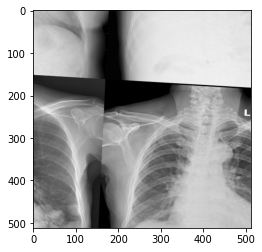

(512, 512, 3)


TypeError: Expected Ptr<cv::UMat> for argument 'img'

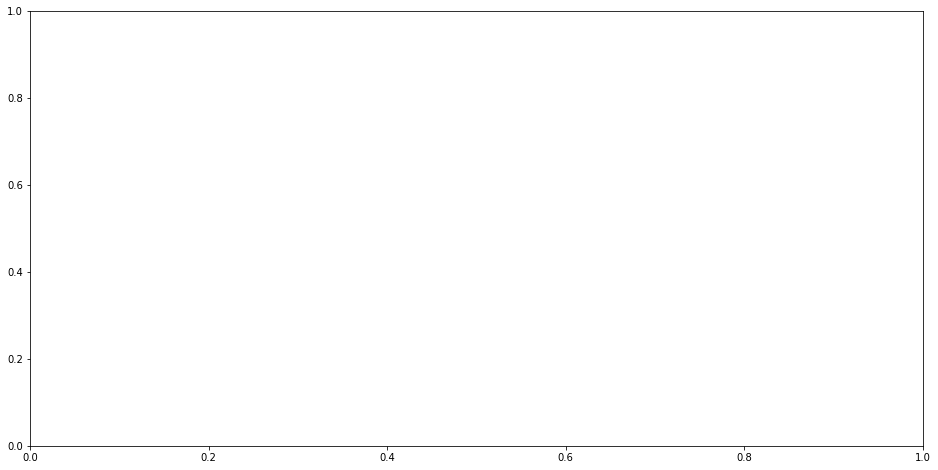

In [99]:
image, target, image_id = train_dataset[1]
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 1, 0), 2)

plt.imshow(numpy_image)
plt.show()